In [1]:
import xarray as xr
import numpy as np
from collections import namedtuple
import regionmask
import datetime
import pandas as pd
from scores.continuous import rmse
import matplotlib.pyplot as plt

# Permutation Notes

As I'm writing out the MWE's, here's some notes on what I think might need to be accounted for:

1. Models that run every 3, 6, 12, 24 hours and how that translates to the max/min metrics (all valid times in a 12 hour frequency/6 hour resolution have 21 lead times, for example, compared to 6/6 runs with 41)
2. When to aggregate over lat/lons for area-averaged metrics
3. When to remove ocean gridpoints to avoid improper comparisons (e.g. forecasts spatially aggregated with ocean vs ERA5 aggregated without)
4. I am using a stand-in value of >= 2 days 20C minimum temp for the "heatwave". The start and end dates on the case are the analyzed heat wave, but the same needs to be determined in the models for onset and duration ME. We determined >= 2 days where the minimum temperature > 85th percentile is a heat wave case (EPA definition). There is scaffolding needed to pull in the 85th percentile climatology from the bucket. Also, the edge cases of: no heat wave, fragmented heat wave, heat waves in the wrong timeframe, and "never ending heat wave" (e.g. fills the whole forecast).

In [203]:
def convert_longitude_to_360(longitude: float) -> float:
    """Convert a longitude from the range [-180, 180) to [0, 360)."""
    return np.mod(longitude, 360)

def lead_time_init_time_to_valid_time(forecast):
    """Convert init_time and lead_time to valid_time.
    
    Args:
        forecast: The forecast dataset.

    Returns:
        The forecast dataset with valid_time dimension.
    """
    if 'lead_time' not in forecast.dims or 'init_time' not in forecast.dims:
        raise ValueError("lead_time and init_time must be dimensions of the forecast dataset")
    
    lead_time_grid, init_time_grid = np.meshgrid(forecast.lead_time, forecast.init_time)
    valid_times = (
    init_time_grid.flatten()
    + pd.to_timedelta(lead_time_grid.flatten(), unit="h").to_numpy()
    )
    return valid_times

# Subset timesteps for forecast
def derive_indices_from_init_time_and_lead_time(
    dataset: xr.Dataset,
    start_date: datetime.datetime,
    end_date: datetime.datetime,
) -> np.ndarray:
    """Derive the indices of valid times in a dataset when the dataset has init_time and lead_time coordinates.

    Args:
        dataset: The dataset to derive the indices from.
        start_date: The start date to derive the indices from.
        end_date: The end date to derive the indices from.

    Returns:
        The indices of valid times in the dataset.

    Example:
        >>> import xarray as xr
        >>> import datetime
        >>> import pandas as pd
        >>> from extremeweatherbench.utils import (
        ...     derive_indices_from_init_time_and_lead_time,
        ... )
        >>> ds = xr.Dataset(
        ...     coords={
        ...         "init_time": pd.date_range("2020-01-01", "2020-01-03"),
        ...         "lead_time": [0, 24, 48],  # hours
        ...     }
        ... )
        >>> start = datetime.datetime(2020, 1, 1)
        >>> end = datetime.datetime(2020, 1, 4)
        >>> indices = derive_indices_from_init_time_and_lead_time(ds, start, end)
        >>> print(indices)
        array([0, 0, 1, 1, 2])
    """
    valid_times = lead_time_init_time_to_valid_time(dataset)
    valid_times_reshaped = valid_times.reshape(
        (
            dataset.init_time.shape[0],
            dataset.lead_time.shape[0],
        )
    )
    valid_time_mask = (valid_times_reshaped > pd.to_datetime(start_date)) & (
        valid_times_reshaped < pd.to_datetime(end_date)
    )
    valid_time_indices = np.asarray(valid_time_mask).nonzero()

    # The first index will subset init_time based on the first valid_time_reshaped line above
    # we don't need to subset lead_time but it might be useful in the future
    init_time_subset_indices = valid_time_indices[0]

    return init_time_subset_indices

def remove_ocean_gridpoints(dataset: xr.Dataset,drop: bool = True) -> xr.Dataset:
    """Subset a dataset to only include land gridpoints based on a land-sea mask.

    Args:
        dataset: The input xarray dataset.

    Returns:
        The dataset masked to only land gridpoints.
    """
    land = regionmask.defined_regions.natural_earth_v5_0_0.land_110
    land_sea_mask = land.mask(dataset.longitude, dataset.latitude)
    land_mask = land_sea_mask == 0
    # Subset the dataset to only include land gridpoints
    return dataset.where(land_mask, drop=drop)


In [3]:
#event metadata
start_date = pd.Timestamp('2021-06-22 00:00')
end_date = pd.Timestamp('2021-07-02 00:00')
Location = namedtuple('Location', ['latitude', 'longitude'])
location = Location(latitude=47.608013, longitude=-122.335167)
bounding_box_degrees = 5


In [4]:
#: Storage location for GHCN.
GHCN_URI = "gs://extremeweatherbench/datasets/ghcnh.parq"#Parquet filters
filters = [('time', '>=', start_date - pd.Timedelta(days=2)),
           ('time', '<=', end_date + pd.Timedelta(days=2)),
           ('latitude', '<=', location.latitude+bounding_box_degrees/2),
           ('latitude', '>=', location.latitude-bounding_box_degrees/2),
           ('longitude', '<=', location.longitude+bounding_box_degrees/2),
           ('longitude', '>=', location.longitude-bounding_box_degrees/2)]
ghcn = pd.read_parquet(GHCN_URI, storage_options=dict(token="anon"),filters=filters).set_index(
[
    "station",
    "time"
]
).sort_index()

#Convert parquet to dataset

ghcn_ds = xr.Dataset.from_dataframe(ghcn)
ghcn_ds['latitude'] = ghcn_ds['latitude'].where(ghcn_ds['latitude'].notnull()).bfill(dim='time').isel(time=0)
ghcn_ds['longitude'] = ghcn_ds['longitude'].where(ghcn_ds['longitude'].notnull()).bfill(dim='time').isel(time=0)
ghcn_ds = ghcn_ds.assign_coords(latitude=ghcn_ds.latitude.astype(float), longitude=ghcn_ds.longitude.astype(float)) 
ghcn_ds['longitude'] = convert_longitude_to_360(ghcn_ds['longitude'])
ghcn_ds = ghcn_ds.rename({'time':'valid_time'}).swap_dims({'station': 'location'}).set_index(location=('latitude','longitude'))
prepared_ghcn = ghcn_ds[['surface_air_temperature']].rename({'surface_air_temperature':'2m_temperature'})
prepared_ghcn['2m_temperature'] = prepared_ghcn['2m_temperature']+273.15

In [5]:
#: Storage location for ERA5.
ERA5_URI = "gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3"
era5 = xr.open_zarr(
    ERA5_URI,
    chunks=None,
    storage_options=dict(token="anon"),
)
#Convert ERA5 to event dates
era5_case = era5.sel(
    time=slice(
        start_date,
        end_date,
    )
)
#Take heatwave variable
era5_case = era5_case[['2m_temperature']]

era5_case = era5_case.sel(
    latitude=slice(location.latitude+bounding_box_degrees/2,location.latitude-bounding_box_degrees/2),
    longitude=slice(convert_longitude_to_360(location.longitude)-bounding_box_degrees/2, convert_longitude_to_360(location.longitude)+bounding_box_degrees/2)
).rename({'time':'valid_time'})

prepared_era5 = remove_ocean_gridpoints(era5_case,drop=False)

In [6]:
# Forecast
forecast_dir = "gs://weatherbench2/datasets/hres/2016-2022-0012-1440x721.zarr"
forecast_ds = xr.open_zarr(forecast_dir, chunks="auto")
forecast_ds = forecast_ds.rename({'prediction_timedelta':'lead_time','time':'init_time'})

#HRES reverse of ERA5 for latitude slicing
forecast_case = forecast_ds['2m_temperature']
forecast_case = forecast_case.sel(
    latitude=slice(location.latitude-bounding_box_degrees/2,location.latitude+bounding_box_degrees/2),
    longitude=slice(convert_longitude_to_360(location.longitude)-bounding_box_degrees/2, convert_longitude_to_360(location.longitude)+bounding_box_degrees/2)
)

valid_times = lead_time_init_time_to_valid_time(forecast_case)
# Create new dataset with valid_time dimension
subset_forecast_flat = forecast_case.stack(time_stack=['init_time', 'lead_time'])
subset_forecast_flat=subset_forecast_flat.assign_coords(valid_time=(('time_stack'), valid_times)).swap_dims({'time_stack':'valid_time'})

# Subset forecast valid times to the tolerance range (for heatwaves, 48 hours)
# The tolerance range is used to capture biases in case timing (e.g. the forecast heat wave initialization was 1 day early)
forecast_time_mask = (subset_forecast_flat.valid_time >= start_date-pd.Timedelta(days=2)) & (subset_forecast_flat.valid_time <= end_date+pd.Timedelta(days=2))

## Added compute here because fastest by at least 10 seconds
subset_forecast_flat = subset_forecast_flat.where(forecast_time_mask,drop=True).compute()

# subset_forecast_flat = remove_ocean_gridpoints(subset_forecast_flat,drop=False)
prepared_forecast = subset_forecast_flat.set_index(time_stack=['lead_time','valid_time']).unstack('time_stack')

# Regional RMSE

In [87]:
rmse_era5_output = rmse(prepared_forecast,prepared_era5,preserve_dims='lead_time').compute()

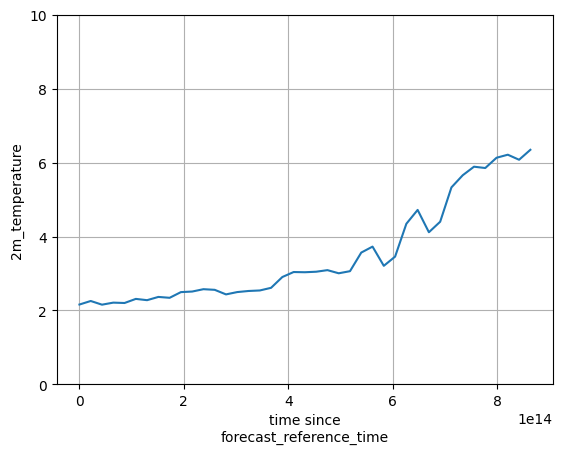

In [88]:
rmse_era5_output['2m_temperature'].plot()
plt.ylim(0,10)
plt.grid()
plt.show()

In [9]:
lons = xr.DataArray(
            prepared_ghcn["longitude"].values, dims="location"
        )
lats = xr.DataArray(
    prepared_ghcn["latitude"].values, dims="location"
)

prepared_forecast_for_ghcn = prepared_forecast.interp(latitude=lats, longitude=lons, method="nearest")
prepared_forecast_for_ghcn = prepared_forecast_for_ghcn.set_index(location=('latitude','longitude'))

In [10]:
rmse_ghcn_output = rmse(prepared_forecast_for_ghcn,prepared_ghcn,preserve_dims=['lead_time'])

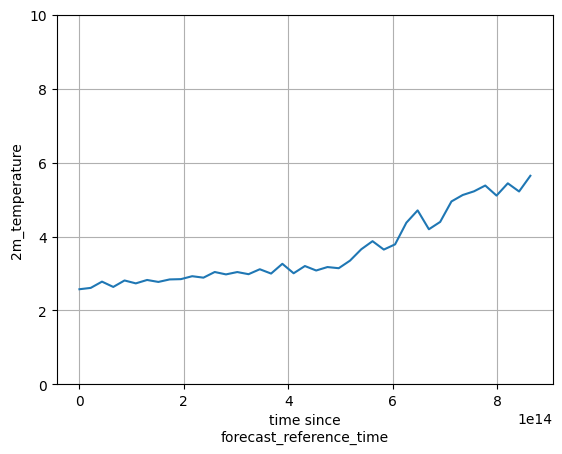

In [11]:
rmse_ghcn_output['2m_temperature'].plot()
plt.ylim(0,10)
plt.grid()
plt.show()

# Maximum MAE

Using the ERA5 spatial mean max to define the timestep of maximum temperature during the case

In [30]:
max_datetime = prepared_era5['2m_temperature'].sel(valid_time=prepared_era5.valid_time.dt.hour.isin([0,6,12,18])).mean(["latitude", "longitude"]).idxmax("valid_time").values
max_era5_avg_value = prepared_era5['2m_temperature'].mean(['latitude','longitude']).sel(valid_time=max_datetime)
max_ghcn_avg_value = prepared_ghcn['2m_temperature'].mean(['location']).sel(valid_time=max_datetime)

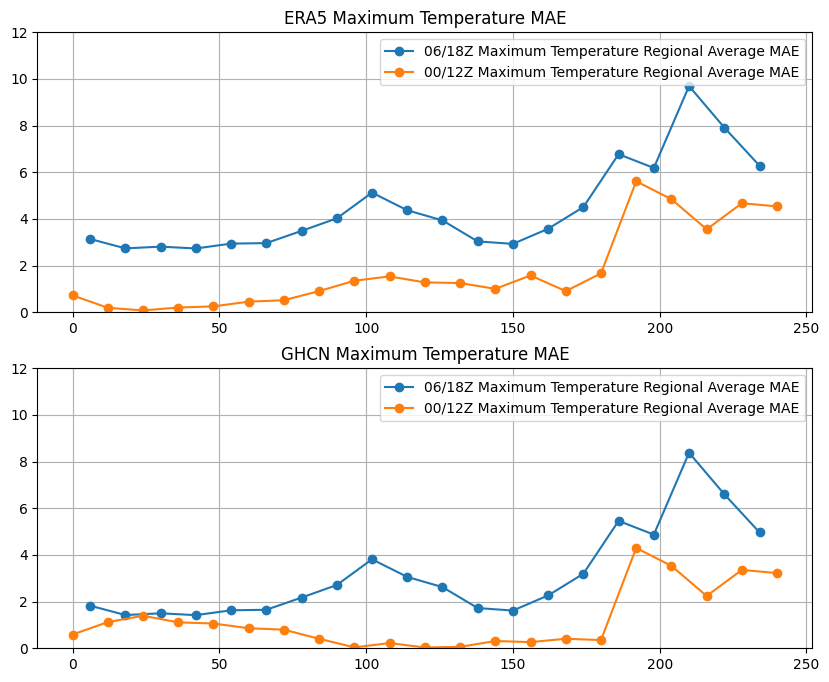

In [227]:
#ERA5 
filtered_max_forecast = remove_ocean_gridpoints(prepared_forecast).mean(['latitude','longitude']).where(
    (prepared_forecast.valid_time >= max_datetime - np.timedelta64(48, 'h')) & 
    (prepared_forecast.valid_time <= max_datetime + np.timedelta64(48, 'h')),
    drop=True
).max('valid_time')

max_era5_avg_mae = abs(filtered_max_forecast - max_era5_avg_value)
max_ghcn_avg_mae = abs(filtered_max_forecast - max_ghcn_avg_value)

fig, ax = plt.subplots(2,1,figsize=(10,8))
t=max_era5_avg_mae[1::2]['lead_time'].values.astype("timedelta64[h]")
ax[0].plot(t,max_era5_avg_mae[1::2],label='06/18Z Maximum Temperature Regional Average MAE',marker='o')

t=max_era5_avg_mae[::2]['lead_time'].values.astype("timedelta64[h]")
ax[0].plot(t,max_era5_avg_mae[::2],label='00/12Z Maximum Temperature Regional Average MAE',marker='o')

ax[0].set_title('ERA5 Maximum Temperature MAE')
ax[0].legend()
ax[0].grid()
ax[0].set_ylim(0,12)
t = max_ghcn_avg_mae[1::2]['lead_time'].values.astype("timedelta64[h]")
ax[1].plot(t,max_ghcn_avg_mae[1::2],label='06/18Z Maximum Temperature Regional Average MAE',marker='o')

t = max_ghcn_avg_mae[::2]['lead_time'].values.astype("timedelta64[h]")
ax[1].plot(t,max_ghcn_avg_mae[::2],label='00/12Z Maximum Temperature Regional Average MAE',marker='o')

ax[1].set_title('GHCN Maximum Temperature MAE')
ax[1].legend()
ax[1].grid()
ax[1].set_ylim(0,12)
plt.show()


# Highest Minimum Temp MAE

Also using the spatial mean here to determine the highest minimum regional temperatures for analysis.

In [220]:
def min_if_all_timesteps_present_lead_time_valid_time_paradigm(x, num_timesteps: int = 4) -> xr.DataArray:
    """Return the minimum value of a DataArray if all timesteps of a day are present given a dataset with lead_time and valid_time dimensions.
    
    Args:
        da: The input DataArray.

    Returns:
        The minimum value of the DataArray if all timesteps are present, otherwise the original DataArray.
    """
    if len(x.valid_time) == num_timesteps:
        return x.min('valid_time')
    else:
        return xr.DataArray(np.nan)
    
    
def min_if_all_timesteps_present(x,num_timesteps: int) -> xr.DataArray:
    """Return the minimum value of a DataArray if all timesteps of a day are present.
    
    Args:
        da: The input DataArray.

    Returns:
        The minimum value of the DataArray if all timesteps are present, otherwise the original DataArray.
    """
    if len(x.values) == num_timesteps:
        return x.min()
    else:
        return xr.DataArray(np.nan)

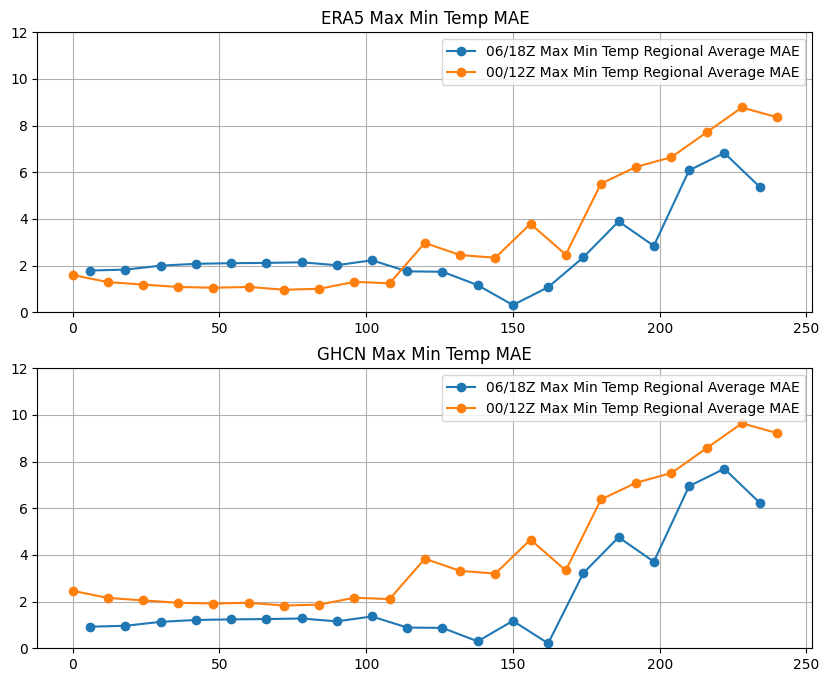

In [ ]:
max_min_era5_value = (
    prepared_era5['2m_temperature']
    .mean(['latitude','longitude'])
    .sel(valid_time=prepared_era5.valid_time.dt.hour.isin([0,6,12,18]))
    .groupby("valid_time.dayofyear")
    .map(min_if_all_timesteps_present,num_timesteps=4)
    .max() 
    )
max_min_era5_datetime = prepared_era5.mean(['latitude','longitude']).where(prepared_era5.mean(['latitude','longitude'])['2m_temperature'] == max_min_era5_value,drop=True).valid_time.values
max_min_ghcn_value = prepared_ghcn['2m_temperature'].mean(['location']).sel(valid_time=max_min_era5_datetime)

filtered_max_min_forecast = remove_ocean_gridpoints(prepared_forecast).mean(['latitude','longitude']).where(
    (prepared_forecast.valid_time >= max_min_era5_datetime - np.timedelta64(48, 'h')) & 
    (prepared_forecast.valid_time <= max_min_era5_datetime + np.timedelta64(48, 'h')),
    drop=True
).groupby("valid_time.dayofyear").map(min_if_all_timesteps_present_lead_time_valid_time_paradigm,num_timesteps=4).min('dayofyear')


max_min_era5_avg_mae = abs(filtered_max_min_forecast - max_min_era5_value)
max_min_ghcn_avg_mae = abs(filtered_max_min_forecast - max_min_ghcn_value)

fig, ax = plt.subplots(2,1,figsize=(10,8))
t=max_min_era5_avg_mae[1::2]['lead_time'].values.astype("timedelta64[h]")
ax[0].plot(t,max_min_era5_avg_mae[1::2],label='06/18Z Max Min Temp Regional Average MAE',marker='o')

t=max_min_era5_avg_mae[::2]['lead_time'].values.astype("timedelta64[h]")
ax[0].plot(t,max_min_era5_avg_mae[::2],label='00/12Z Max Min Temp Regional Average MAE',marker='o')

ax[0].set_title('ERA5 Max Min Temp MAE')
ax[0].legend()
ax[0].grid()
ax[0].set_ylim(0,12)
t = max_min_ghcn_avg_mae[1::2]['lead_time'].values.astype("timedelta64[h]")
ax[1].plot(t,max_min_ghcn_avg_mae[1::2],label='06/18Z Max Min Temp Regional Average MAE',marker='o')

t = max_min_ghcn_avg_mae[::2]['lead_time'].values.astype("timedelta64[h]")
ax[1].plot(t,max_min_ghcn_avg_mae[::2],label='00/12Z Max Min Temp Regional Average MAE',marker='o')

ax[1].set_title('GHCN Max Min Temp MAE')
ax[1].legend()
ax[1].grid()
ax[1].set_ylim(0,12)
plt.show()

# Onset ME

In [277]:
onset_era5 = pd.Timestamp('2021-06-29 00:00')

In [290]:
def test_onset(x):
    if (x.valid_time.max() - x.valid_time.min()).values.astype('timedelta64[h]') >= 48:
        min_daily_vals = x.groupby('valid_time.dayofyear').map(min_if_all_timesteps_present,num_timesteps=4)
        # need to determine logic for 2+ consecutive days to find the date that the heatwave starts
        if len(min_daily_vals) >= 2:  # Check if we have at least 2 values
            for i in range(len(min_daily_vals)-1):
                if min_daily_vals[i] >= 288.15 and min_daily_vals[i+1] >= 288.15:
                    return xr.DataArray(x.where(x['valid_time'].dt.dayofyear==min_daily_vals.dayofyear[i],drop=True).valid_time[0].values)
                else:
                    return xr.DataArray(np.datetime64("NaT",'ns'))
        else:
            return xr.DataArray(np.datetime64("NaT",'ns'))
    else:
        return xr.DataArray(np.datetime64("NaT",'ns'))

In [296]:
onset_forecast = prepared_forecast.mean(['latitude','longitude']).groupby('init_time').map(test_onset)

onset_me = pd.to_datetime(onset_forecast) - onset_era5

onset_me

TimedeltaIndex([      NaT,       NaT,       NaT,       NaT,       NaT,
                      NaT,       NaT,       NaT,       NaT,       NaT,
                      NaT,       NaT,       NaT,       NaT,       NaT,
                      NaT,       NaT,       NaT,       NaT,       NaT,
                      NaT,       NaT,       NaT,       NaT,       NaT,
                      NaT,       NaT,       NaT,       NaT,       NaT,
                      NaT,       NaT, '-3 days',       NaT, '-2 days',
                      NaT, '-1 days',       NaT,  '0 days',       NaT,
                 '1 days',       NaT,       NaT,       NaT,       NaT,
                      NaT,       NaT,       NaT,       NaT],
               dtype='timedelta64[ns]', freq=None)

# Duration ME

In [294]:
made_up_duration_number = 4

In [295]:
def test_duration(x):
    if (x.valid_time.max() - x.valid_time.min()).values.astype('timedelta64[h]') >= 48:
        min_daily_vals = x.groupby('valid_time.dayofyear').map(min_if_all_timesteps_present,num_timesteps=4)
        # need to determine logic for 2+ consecutive days to find the date that the heatwave starts
        if len(min_daily_vals) >= 2:  # Check if we have at least 2 values
            for i in range(len(min_daily_vals)-1):
                if min_daily_vals[i] >= 288.15 and min_daily_vals[i+1] >= 288.15:
                    consecutive_days = 2.  # Start with 2 since we found first pair
                    for j in range(i+2, len(min_daily_vals)):
                        if min_daily_vals[j] >= 288.15:
                            consecutive_days += 1
                        else:
                            break
                    return xr.DataArray(consecutive_days)
                else:
                    return xr.DataArray(np.nan)
        else:
            return xr.DataArray(np.nan)
    else:
        return xr.DataArray(np.nan)
    
duration_forecast = prepared_forecast.mean(['latitude','longitude']).groupby('init_time').map(test_duration)
duration_me = duration_forecast - made_up_duration_number
duration_me

<xarray.DataArray (init_time: 49)> Size: 392B
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan,  1., nan,  1., nan,  0., nan, -1.,
       nan, -2., nan, nan, nan, nan, nan, nan, nan, nan])
Coordinates:
  * init_time  (init_time) datetime64[ns] 392B 2021-06-10 ... 2021-07-04